#深層距離学習で異常検知をしてみよう

##これまでの内容
+ CIFAR-10（カラー）を題材に、オートエンコーダを使って異常検知
+ 正常：猫、異常：犬にして学習
+ オートエンコーダではCIFAR-10に太刀打ちできなかった
+ 深層距離学習の登場
 + 似たもの同士を近くにプロットしてくれるために、異常検知にも応用が可能

##今回の内容
+ 深層距離学習（L2-SoftmaxLoss）で異常検知リベンジ
+ 深層距離学習による異常検知の最前線

##データロード

In [0]:
from keras.models import Model
from keras.layers import Input, Conv2D
from keras.layers import Conv2DTranspose, LeakyReLU
from keras.layers.core import Activation
from keras.optimizers import Adam
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import cifar10, fashion_mnist
import cv2

def data_choice(x, label, size=8000):
    number = np.random.choice(np.arange(0, len(x)), size, replace=False)
    normal, anomaly, ref = [], [], []
    normal_y, anomaly_y, ref_y = [], [], []
    for i in range(len(number)):
        fig = cv2.resize(x[number[i]], (96,96))
        if label[number[i]] == 3:# cat
            normal.append(fig)
            normal_y.append(label[number[i]])
        elif label[number[i]] == 5:# dog
            anomaly.append(fig)
        else:
            ref.append(fig) #others
            ref_y.append(label[number[i]])

    return np.array(normal), np.array(anomaly), np.array(ref), np.array(normal_y), np.array(ref_y)

def get_data():
    # dataset
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    #(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

    #x_train = np.expand_dims(x_train, axis=-1)
    #x_test = np.expand_dims(x_test, axis=-1)

    x_train = x_train.astype('float32') / 255
    x_test = x_test.astype('float32') / 255

    x_train_normal, _, x_train_ref, y_train_normal, y_train_ref = data_choice(x_train, y_train)
    x_test_normal, x_test_anomaly, _, _, _ = data_choice(x_test, y_test)

    return x_train_normal, x_train_ref, y_train_normal, y_train_ref, x_test_normal, x_test_anomaly

def plot_fig(fig1, fig2, fig3, anomaly_detection=False):
    plt.figure(figsize=(11,45))
    plt.subplot(1,3,1)
    plt.imshow(fig1)
    if anomaly_detection:
        plt.title("Original data")
    else:
        plt.title("Train normal data")

    plt.subplot(1,3,2)
    plt.imshow(fig2)
    if anomaly_detection:
        plt.title("Reconstruction data")
    else:
        plt.title("Test normal data")

    plt.subplot(1,3,3)
    if anomaly_detection:
        plt.imshow(np.sum(np.abs(fig3), axis=-1), cmap="gray")
        plt.title("difference data(score=%d)" % np.sum(np.abs(fig3)))
    else:
        plt.imshow(fig3)
        plt.title("Test anomaly data")
    plt.show()

Using TensorFlow backend.


In [0]:
x_train_normal, x_train_ref, y_train_normal, y_train_ref, x_test_normal, x_test_anomaly = get_data()

170500096/170498071 [==============================] - 4s 0us/step


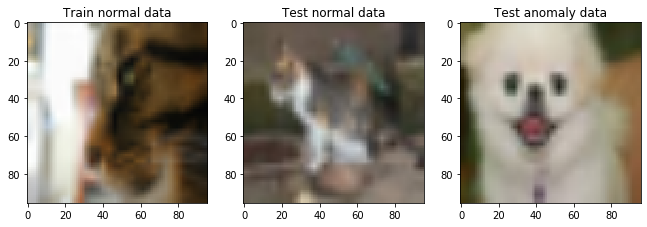

In [0]:
plot_fig(x_train_normal[10], x_test_normal[10], x_test_anomaly[10])

##L2-SoftmaxLoss

In [0]:
from keras.applications import MobileNetV2, VGG16
from keras.optimizers import Adam, SGD
from keras.models import Model
from keras.layers import GlobalAveragePooling2D, Dense
from keras import backend as K
import keras
from keras.engine.network import Network
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics

def train_L2(x, label):
    y = keras.utils.to_categorical(label)
    classes = y.shape[1]

    print("L2-SoftmaxLoss training...")
    mobile = MobileNetV2(include_top=False, input_shape=x.shape[1:], alpha=0.5,
                         weights='imagenet')
    
    # L2層と全結合層を付ける
    c = GlobalAveragePooling2D()(mobile.output)
    c = keras.layers.Lambda(lambda xx: 15*(xx)/K.sqrt(K.sum(xx**2)))(c) #metric learning
    c = Dense(classes, activation='softmax')(c)
    model = Model(inputs=mobile.input,outputs=c)

    #model.summary()

    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(lr=0.0001, amsgrad=True),
                  metrics=['accuracy'])

    #学習
    hist = model.fit(x, y, batch_size=128, epochs=50, verbose = True)

    #plt.figure()               
    #plt.plot(hist.history['acc'],label="train_acc")
    #plt.legend(loc="lower right")
    #plt.show()

    return Model(inputs=model.input,outputs=model.layers[-2].output)

def get_auc(Z1, Z2):
    y_true = np.zeros(len(Z1)+len(Z2))
    y_true[len(Z1):] = 1#0:正常、1：異常

    # FPR, TPR(, しきい値) を算出
    fpr, tpr, _ = metrics.roc_curve(y_true, np.hstack((Z1, Z2)))

    # AUC
    auc = metrics.auc(fpr, tpr)

    return fpr, tpr, auc

def auc(Z1, Z2):
    fpr, tpr, auc = get_auc(Z1, Z2)

    # Z1, Z2をプロット
    plt.figure(figsize=(10,6))
    plt.plot(Z1, label="normal")
    plt.plot(Z2, label="anomaly")
    plt.ylim(-1,3)
    plt.legend()
    plt.title('Anomaly score')
    plt.grid(True)
    plt.show()

    # ROC曲線をプロット
    plt.plot(fpr, tpr, label='L2-SoftmaxLoss(AUC = %.2f)'%auc)
    plt.legend()
    plt.title('ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid(True)
    plt.show()

def get_score(model, x_train_normal, x_test_normal, x_test_anomaly):
    train = model.predict(x_train_normal, batch_size=1)
    test_s = model.predict(x_test_normal, batch_size=1)
    test_b = model.predict(x_test_anomaly, batch_size=1)

    train = train.reshape((len(train),-1))
    test_s = test_s.reshape((len(test_s),-1))
    test_b = test_b.reshape((len(test_b),-1))

    ms = MinMaxScaler()
    train = ms.fit_transform(train)
    test_s = ms.transform(test_s)
    test_b = ms.transform(test_b)

    # fit the model
    clf = LocalOutlierFactor(n_neighbors=5)
    y_pred = clf.fit(train[:1000])

    # plot the level sets of the decision function
    Z1 = -clf._decision_function(test_s)
    Z2 = -clf._decision_function(test_b)

    return Z1, Z2

##Experiment

In [0]:
#L2-SoftmaxLoss
model = train_L2(np.vstack((x_train_normal, x_train_ref)), np.vstack((y_train_normal, y_train_ref)))
Z1, Z2 = get_score(model, x_train_normal, x_test_normal, x_test_anomaly)

auc(Z1, Z2)

#オートエンコーダ（32 * 32→96 * 96）

In [0]:
def train_AE(x):
    # build encoder
    inputs = Input(x.shape[1:])
    c = Conv2D(32, (5, 5), padding='same', strides=(2,2))(inputs)
    c = Activation('relu')(c)#48*48
  
    c = Conv2D(64, (5, 5), padding='same', strides=(2,2))(c)
    c = Activation('relu')(c)#24*24

    # build decoder
    c = Conv2DTranspose(32, (5, 5), padding='same', strides=(2,2))(c)
    c = Activation('relu')(c)#48*48
  
    c = Conv2DTranspose(3, (5, 5), padding='same', strides=(2,2))(c)
    c = Activation('sigmoid')(c)#96*96
  
    # build ae
    ae =  Model(inputs, c)

    ae.compile(optimizer=Adam(lr=0.0002, beta_1=0.5), loss="mse")

    hist = ae.fit(x, x,
                  epochs=100,
                  verbose=True,
                  batch_size=128)
    
    return ae
    
def get_score_ae(model, x_test_normal, x_test_anomaly):
    normal_score = np.abs(model.predict(x_test_normal) - x_test_normal)
    normal_score = np.sum(normal_score.reshape(len(normal_score),-1),axis=1)

    anomaly_score = np.abs(model.predict(x_test_anomaly) - x_test_anomaly)
    anomaly_score = np.sum(anomaly_score.reshape(len(anomaly_score),-1),axis=1)

    return normal_score, anomaly_score

In [0]:
#AE
ae = train_AE(x_train_normal)
Z1, Z2 = get_score_ae(ae, x_test_normal, x_test_anomaly)

auc(Z1, Z2)

#考察
##なぜ、深層距離学習だと異常検知性能が良くなったのか？
→深層距離学習は、差分をとる手法ではないから

||オートエンコーダ|深層距離学習|
|---|---|---|
|背景|影響を受ける|無視できる|
|細かい異常|検知難しい|検知可能|
|転移学習|ほとんど不可|使用可能|
|※推論速度|2sec（例えば）|1sec|

AUCの比較(CIFAR10 cat_vs_dog)

||通常学習|転移学習使用|
|---|---|---|
|オートエンコーダ|0.53|-|
|深層距離学習|0.54|**0.66**|


##深層距離学習のデメリット
+ **強引にラベルを用意する必要がある。**（外部画像を用いたり、自己教師あり学習を使ったり...）
 + オートエンコーダはラベル不要
+ [可視化](https://qiita.com/shinmura0/items/06d81c72601c7578c6d3#%E5%8F%AF%E8%A6%96%E5%8C%96)もラベル付与と共に、その都度検討する必要がある

#深層距離学習による異常検知の最前線
+ 深層距離学習で一番良いスコアが出やすいのは[ArcFace](https://qiita.com/yu4u/items/078054dfb5592cbb80cc)。実装は[こちら](https://qiita.com/shinmura0/items/06d81c72601c7578c6d3#%E5%AE%9F%E8%A3%85)
+ 今のところ、**工業製品**をターゲットにすると、ラベルの付け方で一番スコアが高いのは[自己教師あり学習](https://qiita.com/daisukelab/items/e0ff429bd58b2befbb1b#%E5%AE%9F%E9%A8%933%E9%80%9A%E5%B8%B8%E3%81%AE%E3%82%B5%E3%83%B3%E3%83%97%E3%83%AB%E3%81%8B%E3%82%89%E7%95%B0%E5%B8%B8%E3%81%AA%E3%82%B5%E3%83%B3%E3%83%97%E3%83%AB%E3%82%92%E7%94%9F%E6%88%90%E3%81%99%E3%82%8B%E8%87%AA%E5%B7%B1%E6%95%99%E5%B8%AB%E3%81%82%E3%82%8A%E5%AD%A6%E7%BF%92)
 + 可視化もGrad-CAMが使える